<a href="https://colab.research.google.com/github/MalakAhmed2003/Cellula/blob/main/Cellula_Task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

print("Top-level:", os.listdir("dataset"))

first = os.listdir("dataset")[0]
print("Inside first folder:", os.listdir(f"dataset/{first}"))


Top-level: ['Teeth_Dataset']
Inside first folder: ['Testing', 'Training', 'Validation']


Downloading...
From (original): https://drive.google.com/uc?id=1WEySXMFz6v1OgPkLKJ8QIp3Lk-eyTObY
From (redirected): https://drive.google.com/uc?id=1WEySXMFz6v1OgPkLKJ8QIp3Lk-eyTObY&confirm=t&uuid=794c1df2-5140-4b18-96fb-71aa61374351
To: /content/dataset.zip
100%|██████████| 49.1M/49.1M [00:00<00:00, 109MB/s]


Top-level folders: ['Teeth_Dataset']
Inside Teeth_Dataset: ['Testing', 'Training', 'Validation']
Detected classes: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


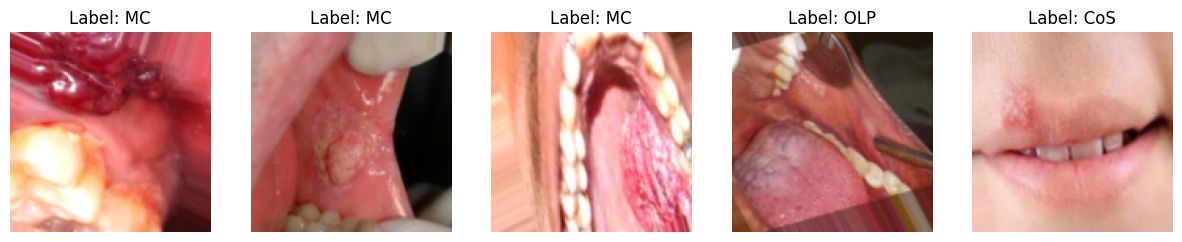

In [ ]:

!pip install -q gdown

import gdown
import zipfile
import os
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

file_id = "1WEySXMFz6v1OgPkLKJ8QIp3Lk-eyTObY"
url = f"https://drive.google.com/uc?id={file_id}"
gdown.download(url, "dataset.zip", quiet=False)

with zipfile.ZipFile("dataset.zip", "r") as zip_ref:
    zip_ref.extractall("dataset")

print("Top-level folders:", os.listdir("dataset"))
print("Inside Teeth_Dataset:", os.listdir("dataset/Teeth_Dataset"))

zation for pretrained models)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(root="dataset/Teeth_Dataset/Training", transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


print("Detected classes:", dataset.classes)


data_iter = iter(dataloader)
images, labels = next(data_iter)

fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img = images[i].numpy().transpose((1, 2, 0))

    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    ax[i].imshow(img)
    ax[i].set_title(f"Label: {dataset.classes[labels[i]]}")
    ax[i].axis('off')
plt.show()


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )


        self._to_linear = None
        self._initialize_linear_layer()

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self._to_linear, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def _initialize_linear_layer(self):
               with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 128, 128)
            dummy_output = self.features(dummy_input)
            self._to_linear = dummy_output.view(1, -1).shape[1]

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [ ]:
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(dataset.classes))


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader):.4f}, Accuracy: {100 * correct/total:.2f}%")


Epoch 1/5, Loss: 1.9288, Accuracy: 26.37%
Epoch 2/5, Loss: 1.4555, Accuracy: 46.71%
Epoch 3/5, Loss: 0.9877, Accuracy: 64.53%
Epoch 4/5, Loss: 0.5441, Accuracy: 80.86%
Epoch 5/5, Loss: 0.2628, Accuracy: 92.45%


In [ ]:
model.eval()
with torch.no_grad():
    img, label = dataset[40]
    img = img.unsqueeze(0).to(device).to(torch.float)
    output = model(img)
    pred = output.argmax(dim=1).item()
    print(f"Predicted class: {dataset.classes[pred]}")
